In [2]:
pip install foolbox tensorflow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 46.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 17.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 61.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.2
    Uninstalling protobuf-5.28.2:
      Successfully uninstalled protobuf-5.28.2
Note: you may need to restart the kernel to use updated packages.


I0000 00:00:1729612346.603083 3996573 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 11:52:26.932307: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions on original image: [('n02086240', 'Shih-Tzu', 0.9827414), ('n02098413', 'Lhasa', 0.014997913), ('n02086079', 'Pekinese', 0.0009928157)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predictions on poisoned image: [('n02111277', 'Newfoundland', 0.40060642), ('n02108551', 'Tibetan_mastiff', 0.2601052), ('n02086240', 'Shih-Tzu', 0.0865425)]


/hpc/group/wengerlab/hdv2/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predictions on segmented image: [('n03388043', 'fountain', 0.44485164), ('n02504013', 'Indian_elephant', 0.062928155), ('n02480495', 'orangutan', 0.043709528)]


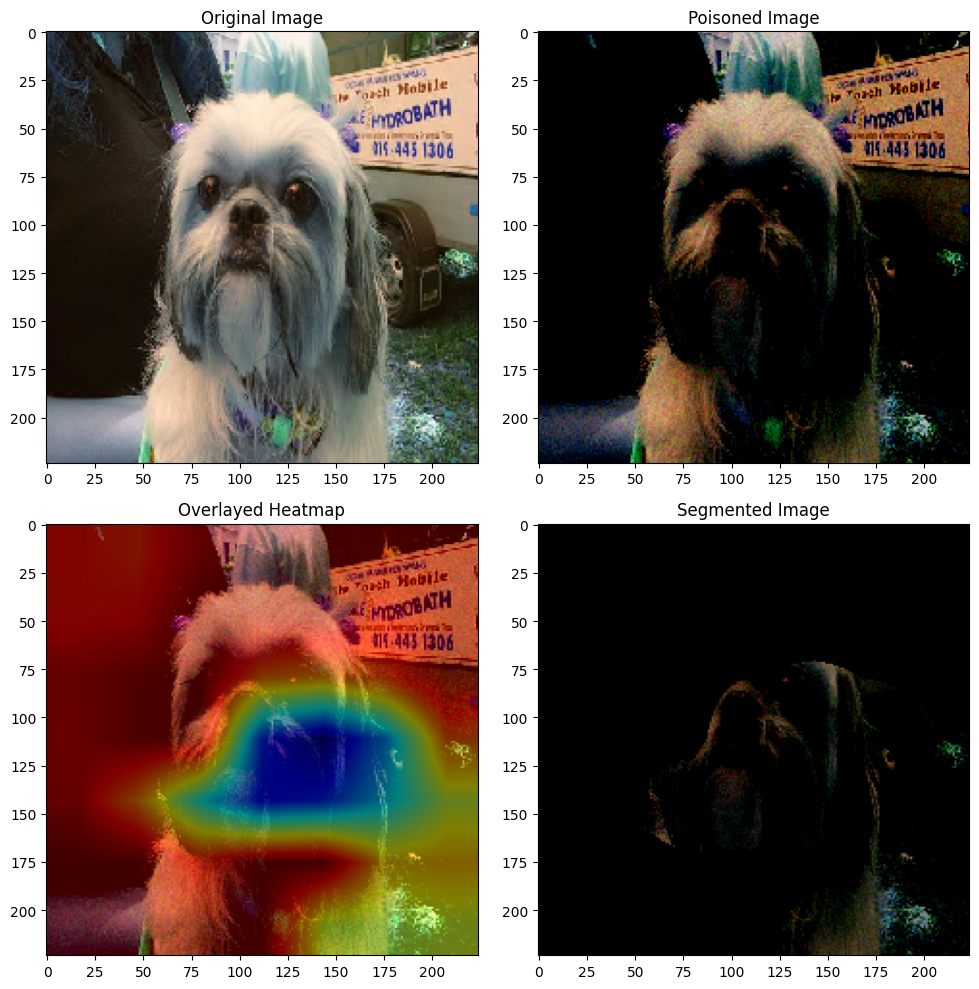

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

# Function to compute Grad-CAM
def get_gradcam_heatmap(model, img_array, layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(conv_outputs)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, predicted_class

# Function to overlay heatmap on the original image
def overlay_heatmap(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed_img = heatmap * alpha + img
    return np.clip(overlayed_img, 0, 255).astype(np.uint8)

# Load a pre-trained model (ResNet50)
model = ResNet50(weights='imagenet')


img_path = '/hpc/group/wengerlab/hdv2/CS590: AI/ML security/dog.jpg' 
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

original_preds = model.predict(x)
print("Predictions on original image:", decode_predictions(original_preds, top=3)[0])


#poison the image by adding noise to every pixel
noise = np.random.normal(0, 10, x.shape)  
poisoned_image = x + noise  
poisoned_image = np.clip(poisoned_image, 0, 255)

# prediction on the poisoned image
poisoned_preds = model.predict(poisoned_image)
print("Predictions on poisoned image:", decode_predictions(poisoned_preds, top=3)[0])



heatmap, predicted_class = get_gradcam_heatmap(model, poisoned_image)
heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
poisoned_img_np = np.uint8(poisoned_image[0])
overlayed_img = overlay_heatmap(poisoned_img_np, heatmap_resized)


threshold = 0.2 
mask = heatmap_resized > threshold
segmented_image = poisoned_img_np * np.expand_dims(mask, axis=-1)  # apply mask to image
segmented_image[~mask] = [0, 0, 0]  # turn non-important pixels black

#make predictions on segmented
segmented_img_exp = np.expand_dims(segmented_image, axis=0)
segmented_img_preprocessed = preprocess_input(segmented_img_exp)
segmented_preds = model.predict(segmented_img_preprocessed)
print("Predictions on segmented image:", decode_predictions(segmented_preds, top=3)[0])





plt.figure(figsize=(10, 10))


plt.subplot(2, 2, 1)
plt.imshow(image.array_to_img(np.squeeze(x)))
plt.title(f"Original Image")


plt.subplot(2, 2, 2)
plt.imshow(image.array_to_img(np.squeeze(poisoned_image)))
plt.title(f"Poisoned Image")


plt.subplot(2, 2, 3)
plt.imshow(overlayed_img)
plt.title("Overlayed Heatmap")


plt.subplot(2, 2, 4)
plt.imshow(segmented_image)
plt.title(f"Segmented Image")

plt.tight_layout()
plt.show()


